In [2]:
import shap
import pandas as pd
import scipy as sp
import numpy as np
from irf.ensemble import wrf
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
from treeinterpreter.feature_importance import feature_importance as FI
from treeinterpreter.feature_importance import MDA

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [75]:
a = rf.estimators_[0].tree_

In [79]:
tmp = copy.deepcopy(a.value.squeeze(axis=1))
node_previous_mean = tmp / np.sum(tmp, 1)[:, np.newaxis]

In [80]:
node_previous_mean

array([[0.45143149, 0.54856851],
       [0.60569106, 0.39430894],
       [0.65944272, 0.34055728],
       ...,
       [0.16666667, 0.83333333],
       [1.        , 0.        ],
       [0.        , 1.        ]])

In [81]:
node_sample_size = a.weighted_n_node_samples
lc = copy.deepcopy(a.children_left)
rc = copy.deepcopy(a.children_right)
tmp = (lc == -1)
lc[tmp] = 0
rc[tmp] = 0
#decrease = node_impurity * node_sample_size - node_impurity[lc] * node_sample_size[lc] - node_impurity[rc] * node_sample_size[rc]
decrease = np.sum( (node_previous_mean - node_previous_mean[lc]) ** 2, 1) * node_sample_size[lc] + \
    np.sum((node_previous_mean - node_previous_mean[rc]) ** 2, 1) * node_sample_size[rc]

In [82]:
decrease

array([2.67837904e+01, 5.43368928e+00, 7.06109011e+00, ...,
       1.66666667e+00, 4.70891207e+03, 3.18891207e+03])

In [87]:
decrease = a.impurity * node_sample_size - a.impurity[lc] * node_sample_size[lc] - a.impurity[rc] * node_sample_size[rc]

In [ ]:
out = np.zeros((X.shape[1], ))
out[a.feature[a.feature != -2]] += decrease

In [105]:
from sklearn.ensemble.forest import _generate_unsampled_indices, _generate_sample_indices
#from sklearn.metrics import accuracy_score, mean_squared_error
#from sklearn.preprocessing import OneHotEncoder
import sklearn
#import numpy as np
import copy

def OOB_MDI(rf, X, y, is_classification = True, min_samples = 2):

    n_samples, n_features = X.shape

    # change X to np.float32
    XX = X.copy().astype(np.float32)

    # infer y.shape
    if len(y.shape) == 1:
        yy = y[:, np.newaxis]
    if is_classification:
        yy = OneHotEncoder().fit_transform(yy)

    if not rf.bootstrap:
        raise ValueError('Without bootstrap, it is not possible to calculate oob.')

    out = np.zeros((n_features,))
    for tree in rf.estimators_:

        indices = _generate_unsampled_indices(tree.random_state, n_samples)
        
        decision_paths = np.array(tree.tree_.decision_path(XX[indices, : ]).todense())
        node_count = decision_paths.shape[1]
        
        # compute the impurity at each node
        node_mean = (decision_paths / np.sum(decision_paths, 0)[np.newaxis, :]).T @ yy[indices, :] 
        tmp = copy.deepcopy(tree.tree_.value.squeeze(axis=1))

        if is_classification:
            node_previous_mean = tmp / np.sum(tmp, 1)[:, np.newaxis]
        else:
            node_previous_mean = tmp
        
        #node_impurity = np.sum(node_mean * node_previous_mean, 1) 
        #node_impurity = np.tensordot(
        #print()
        
        # compute the impurity decrease at each node
        node_sample_size = tree.tree_.weighted_n_node_samples
        lc = copy.deepcopy(tree.tree_.children_left)
        rc = copy.deepcopy(tree.tree_.children_right)
        tmp = (lc == -1)
        lc[tmp] = 0
        rc[tmp] = 0
        #decrease = node_impurity * node_sample_size - node_impurity[lc] * node_sample_size[lc] - node_impurity[rc] * node_sample_size[rc]
        decrease = np.sum((node_mean - node_mean[lc]) * (node_previous_mean - node_previous_mean[lc]), 1) * node_sample_size[lc] + \
            np.sum((node_mean - node_mean[rc]) * (node_previous_mean - node_previous_mean[rc]), 1) * node_sample_size[rc]
        feature = tree.tree_.feature
        decrease[feature == -2] = np.nan
        decrease[np.sum(decision_paths, 0) < min_samples] = np.nan
        tmp = np.logical_not(np.isnan(decrease))
        for i in range(len(tmp)):
            if tmp[i]:
                out[feature[i]] += decrease[i]
        break
    out /= rf.n_estimators
    return out
OOB_MDI(rf, X_train, y_train)

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in true_divide


array([-0.1266692 ,  0.00661685, -0.01537653,  0.0425914 , -0.00853132,
       -0.00287694,  0.05018263,  0.10446435, -0.03329086,  0.08139598,
        0.04228198,  0.07449149,  0.01563731, -0.00521924,  0.06626316,
        0.17890348,  0.00343428,  0.04789609, -0.0117183 ,  0.06015927,
        0.06499134, -0.04282093, -0.00673959, -0.01342857, -0.10053781,
       -0.05077435,  0.15330077,  0.03983232,  0.02677994,  0.0289067 ,
       -0.01214316, -0.0048612 , -0.06381518,  0.03383138,  0.03116533,
       -0.06594669,  0.0172968 , -0.0794969 ,  0.0259371 , -0.03533071,
        0.01475694, -0.04146031,  0.10549364, -0.02703253, -0.08870319,
        0.00341365,  0.        ,  0.02718954, -0.05173401, -0.03500613,
       -0.0187037 , -0.02058583,  0.        ,  0.00857143, -0.12607695,
        0.10525299,  0.02877043, -0.01104088,  0.01454686,  0.06425089,
        0.        ,  0.        ,  0.00415476, -0.09834514,  0.05586088,
        0.01266872, -0.02303531, -0.00326531, -0.02971507, -0.00

# Compare different methods in terms of feature selection using simulated data

### load data

In [3]:
X_train = np.loadtxt('../intermediate/02_enhancer/X_train.csv', delimiter=',')
y_train = np.loadtxt('../intermediate/02_enhancer/y_train.csv', delimiter=',')
X_test = np.loadtxt('../intermediate/02_enhancer/X_test.csv', delimiter=',')
y_test = np.loadtxt('../intermediate/02_enhancer/y_test.csv', delimiter=',')
n, m = X_train.shape
names = np.arange(m)

In [4]:
def sigmoid(x):
    x *= 1
    return np.exp(x) / (np.exp(x) + np.exp(-x))
def permute(X, noisy_features):
    tmp = X.copy()
    for j in range(X.shape[1]):
        if noisy_features[j] == 1:
            tmp[:, j] = np.random.permutation(tmp[:, j])
    return tmp
#def rankdata(X):
#    tmp = X.copy()
#    for j in range(X.shape[1]):
#        #tmp[:, j] = np.random.permutation(sp.stats.rankdata(tmp[:, j]))
#        maximum = max(tmp[:, j])
#        tmp[:, j] = tmp[:, j] / maximum 
#    return tmp
def f(X, noisy_features):
    probs = sigmoid(np.mean(X[:, noisy_features == 0], 1) * 2 - .5)
    return np.array([np.random.choice([0, 1], 1, p=[1 - prob, prob]) for prob in probs]).flatten()

In [5]:
n_features = X_train.shape[1]
n, m = X_train.shape
names = np.arange(m)
noisy_features = np.ones((n_features, ), dtype=int)
noisy_features[np.random.choice(range(n_features), 5, replace=False)] = 0
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = permute(X_train, noisy_features)
X_test = permute(X_test, noisy_features)
y_train = f(X_train, noisy_features)
y_test = f(X_test, noisy_features)


### save intermediate

In [15]:
np.savetxt('../intermediate/02_enhancer/permuted1_X_train.csv', X_train, delimiter=',')
np.savetxt('../intermediate/02_enhancer/permuted1_y_train.csv', y_train, delimiter=',')
np.savetxt('../intermediate/02_enhancer/permuted1_X_test.csv', X_test, delimiter=',')
np.savetxt('../intermediate/02_enhancer/permuted1_y_test.csv', y_test, delimiter=',')
np.savetxt('../intermediate/02_enhancer/permuted1_noisy_features.csv', noisy_features, delimiter=',')

### Train RF

In [6]:
rf = rfc(n_estimators=100, max_features=8, max_depth=100)
rf.fit(X_train, y_train)
gini_imp = rf.feature_importances_

- accuracy

In [7]:
print('accuracy of RF is {0:.3f}'.format(accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))))

accuracy of RF is 0.520


- Plot feature importance

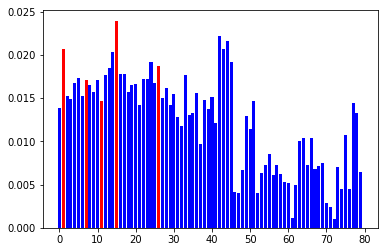

In [8]:
noisy_features = np.array([int(x) for x in noisy_features])
colors = np.array(['red', 'blue'])[noisy_features]
plt.bar(x = np.arange(X_train.shape[1]), height = gini_imp, color = colors)
plt.show()

### prune features based on their importance measures

- classic gini importance

     - plot the gini importance

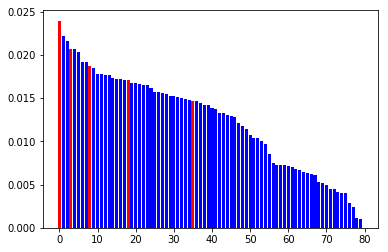

In [9]:
ix = np.argsort(gini_imp * -1)
plt.bar(x = list(range(m)), height = gini_imp[ix], color = colors[ix])
#plt.xticks(list(range(m)), np.array(names)[ix], rotation='vertical')
plt.show()

- debiased gini importance

In [108]:
debiased_fi_mean = OOB_MDI(rf, X_train, y_train, min_samples=40)

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in true_divide


In [95]:
y_train_one_hot = OneHotEncoder().fit_transform(y_train[:, np.newaxis]).todense()

In [96]:
debiased_fi_mean, debiased_fi_std = FI(rf, X_train, y_train_one_hot, type='oob', normalized=False, balanced = False)

    - plot debiased gini importance

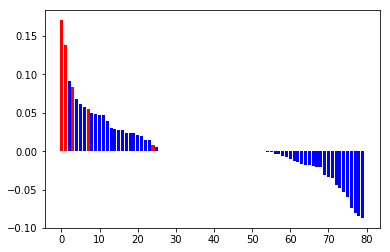

In [109]:
debiased_imp = debiased_fi_mean
ix = np.argsort(debiased_imp * -1)
plt.bar(x = list(range(m)), height = debiased_imp[ix], color=colors[ix])
#plt.xticks(list(range(m)), np.array(names)[ix], rotation='vertical')
plt.show()

- MDA

In [ ]:
MDA_imp, _ = MDA(rf, X_test, y_test[:, np.newaxis], type='test', n_trials=10)
#MDA_imp[MDA_imp < 0] = 0
ix = np.argsort(MDA_imp * -1)
plt.bar(x = list(range(m)), height = MDA_imp[ix], color=colors[ix])
plt.xticks(list(range(m)), np.array(names)[ix], rotation='vertical')
plt.show()

- tree SHAP

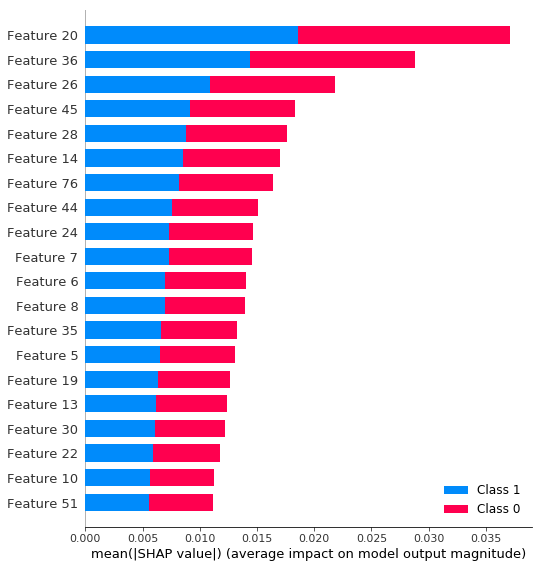

In [14]:
explainer = shap.TreeExplainer(rf)
samples = np.random.choice(range(X_train.shape[0]), 100)
shap_values = explainer.shap_values(X_train[samples, :])
shap.summary_plot(shap_values, X_train[samples, :], plot_type="bar")

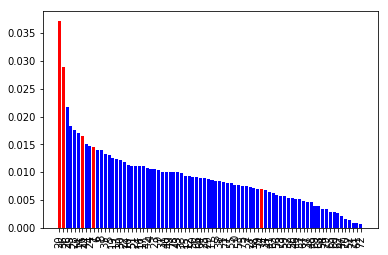

In [15]:
shap_imp = np.mean(abs(shap_values[0]), 0) + np.mean(abs(shap_values[1]), 0)
ix = np.argsort(shap_imp * -1)
plt.bar(x = list(range(m)), height = shap_imp[ix], color=colors[ix])
plt.xticks(list(range(m)), np.array(names)[ix], rotation='vertical')
plt.show()

### Comparison

In [16]:
debiased_imp[debiased_imp < 0] = 0
MDA_imp[MDA_imp < 0] = 0

NameError: name 'MDA_imp' is not defined

In [51]:
roc_auc_score(noisy_features, - debiased_imp)

0.8719999999999999

In [18]:
roc_auc_score(noisy_features, - gini_imp)

0.5840000000000001

In [19]:
roc_auc_score(noisy_features, - shap_imp)

0.8426666666666667

In [ ]:
roc_auc_score(noisy_features, - MDA_imp)

<hr />

### summary of the results from .py file

In [3]:
tmp = np.load('../intermediate/02_simulation_results_correlated_regression.npz')
debiased, gini, shap, mda = [tmp[x] for x in list(tmp)]

In [4]:
tmp2 = pd.read_csv('../intermediate/02_simulation_results_R_correlated_shallow.csv')
gini_R, ranger, cforest = np.array(tmp2.iloc[:, 1]), np.array(tmp2.iloc[:, 2]), np.array(tmp2.iloc[:, 3])
gini_R, ranger, cforest

(array([0.84533333, 0.832     , 0.8       , 0.80533333, 0.59466667,
        0.55733333, 0.70666667, 0.79466667, 0.968     , 0.68      ,
        0.776     , 0.91733333, 0.688     , 0.51733333, 0.65066667,
        0.632     , 0.80266667, 0.688     , 0.77066667, 0.536     ,
        0.456     , 0.64266667, 0.656     , 0.79733333, 0.76      ,
        0.86933333, 0.84266667, 0.936     , 0.60533333, 0.82933333,
        0.824     , 0.80266667, 0.85866667, 0.62666667, 0.656     ,
        0.67733333, 0.62133333, 0.94666667, 0.60266667, 0.78666667]),
 array([0.70933333, 0.86933333, 0.776     , 0.97066667, 0.77066667,
        0.65333333, 0.96533333, 0.96      , 0.992     , 0.79466667,
        0.936     , 0.992     , 0.81866667, 0.784     , 0.72266667,
        0.816     , 0.87733333, 0.73866667, 0.77066667, 0.82666667,
        0.89866667, 0.848     , 0.87466667, 0.83466667, 0.84533333,
        0.85333333, 0.896     , 0.99466667, 0.75733333, 0.87466667,
        0.89066667, 0.896     , 0.76533333, 0.

In [100]:
out = np.array([debiased, shap,ranger, mda, cforest, gini]).T

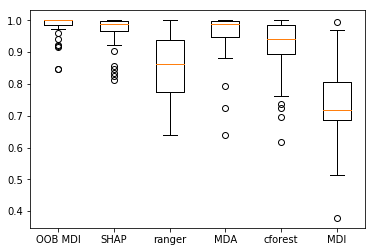

In [101]:
plt.boxplot(out)
plt.xticks(list(range(1, 7)), ['OOB MDI', 'SHAP', 'ranger', 'MDA', 'cforest', 'MDI'])
plt.show()

In [102]:
np.mean(out, 0)

array([0.9806    , 0.96393333, 0.85486667, 0.95666667, 0.9105    ,
       0.73586667])